# Budyko 水文能量平衡分析：从零开始的完整教程

欢迎来到 Budyko 分析的世界！🌊

---

## 📚 本教程的学习目标

通过本教程，你将学会：

1. 理解**水量平衡方程**的物理意义
2. 掌握 Budyko 框架的核心概念（干旱指数、蒸发指数）
3. 了解**径流数据（Q）**为什么是整个分析的基石
4. 学会使用 Python 进行水文数据分析
5. 认识前沿的 Budyko 分析方法（Ibrahim 偏差分析、Jaramillo 轨迹分析）

---

## 🌟 什么是 Budyko 框架？

想象一下，一个流域（比如一条河流的集水区）就像一个大水箱：

- **输入**：降雨（P，Precipitation）
- **输出**：
  - 蒸发（EA，Actual Evaporation）- 水分蒸发回大气
  - 径流（Q，Runoff）- 水流出流域（河流）

水量平衡方程告诉我们：

$$
P = EA + Q + \Delta S
$$

其中 $\Delta S$ 是储量变化（长时间尺度上可忽略）。

**Budyko (1974)** 提出了一个天才的想法：流域的蒸发不仅取决于**供水能力**（P），还取决于**需水能力**（PET，潜在蒸散发）。他用两个无量纲指数来描述这个关系：

- **干旱指数（Aridity Index, IA）**：
  $$
  I_A = \frac{PET}{P}
  $$
  表示"需水"与"供水"的比值。$I_A > 1$ 说明流域缺水（干旱），$I_A < 1$ 说明流域不缺水。

- **蒸发指数（Evaporation Index, IE）**：
  $$
  I_E = \frac{EA}{P}
  $$
  表示实际蒸发占降水的比例。

**Fu (1981)** 给出了著名的 Budyko 曲线方程：

$$
I_E = 1 + I_A - \left(1 + I_A^\omega\right)^{1/\omega}
$$

其中 $\omega$ 是流域特征参数，反映了流域的下垫面特征（植被、土壤等）。

---

## ⚠️ 核心重点：为什么径流数据（Q）是基石？

> **💡 关键洞察**
>
> 在 Budyko 框架中，我们无法直接测量**实际蒸发（EA）**！
>
> 但我们可以测量**径流（Q）**。
>
> 根据水量平衡方程：
> $$
> EA = P - Q - \Delta S \approx P - Q
> $$
>
> 因此，蒸发指数 $I_E$ 完全由观测数据决定：
> $$
> I_E = \frac{EA}{P} = \frac{P - Q}{P} = 1 - \frac{Q}{P}
> $$
>
> **没有径流数据 Q，我们就无法确定 Y 轴（$I_E$）的位置，整个 Budyko 分析就无法进行！**
>
> 可以说，**Q 是连接理论与现实的唯一桥梁**。

---

## 📖 本教程的数据

为了教学目的，我们将生成一个模拟流域的 41 年数据（1980-2020），包括：

- **水文数据**：降水 P、径流 Q
- **气象数据**：温度 T、湿度 RH、风速 u2、辐射 Rn
- **遥感数据**：叶面积指数 LAI、陆地水储量 TWS
- **大气数据**：CO₂ 浓度
- **人为驱动**：灌溉比例

在实际研究中，这些数据来自观测站、卫星遥感和再分析数据集。

---

让我们开始吧！


### 📌 Notebook 版 vs 脚本版
- Notebook：逐格运行、可随时修改参数；适合教学与探索。
- 脚本版：一次性运行、方便批处理。可直接执行 `python notebooks/01_Budyko分析教程_大一新生版.py`。
- 迁移提示：将本 Notebook 的参数改动同步到同名 `.py` 文件的顶部配置段，方便命令行运行。


# 第一部分：环境准备

首先，我们需要导入必要的 Python 库。


In [ ]:
# 第一步：导入基础库（数据处理、路径）
import sys
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path

print("✓ 基础库导入完成")


In [ ]:
# 第二步：配置可视化与项目路径
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# 可选：调整字体与 DPI，保证中文和数学符号正常显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'sans-serif'

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# 将 src 目录加入路径，方便在 Notebook 与脚本版中复用模块
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

print("✓ 可视化配置完成，项目根目录:", project_root)


# 第二部分：导入 Budyko 分析模块

我们的代码库提供了一套完整的 Budyko 分析工具。让我们导入需要的模块：


In [ ]:
# 第三步：导入 Budyko 项目模块
# 在脚本版运行时同样适用；如有包路径冲突，可改为 from src.xxx import ...
from models.pet_models import PenmanMonteithPET
from models.pet_lai_co2 import PETWithLAICO2, PETComparator
from budyko.water_balance import WaterBalanceCalculator
from budyko.curves import BudykoCurves
from budyko.deviation import DeviationAnalysis, TemporalStability, MarginalDistribution
from budyko.trajectory_jaramillo import TrajectoryAnalyzer, MovementStatistics
from analysis.deviation_attribution import DeviationAttributor
from visualization.budyko_plots import BudykoVisualizer

print("✓ Budyko 分析模块导入成功！")


# 第三部分：生成演示数据

## 📌 关于演示数据的说明

在实际项目中，这些数据通常来自：
- **径流数据（Q）**：水文站观测
- **气象数据（P, T, RH, 风速, 辐射）**：气象站或再分析数据（如 CMFD）
- **遥感数据（LAI, TWS）**：卫星产品（MODIS, GRACE）
- **CO₂ 数据**：全球观测站（如 Mauna Loa）

为了教学目的，我们创建一个辅助函数来生成模拟数据。这样可以保持主教程流程的清晰。


In [ ]:
# 第四步：定义生成演示数据的子函数
import numpy as np

def build_precip_runoff(years, start_year, p_mean=800, rc_base=0.4):
    """生成降水 P 与径流 Q，p_mean 与 rc_base 可调整为其他流域特征。"""
    n_years = len(years)
    P = p_mean + 200 * np.sin(2 * np.pi * years / 30) + np.random.normal(0, 100, n_years)
    P = np.maximum(P, 300)
    Q = P * (rc_base + 0.1 * np.sin(2 * np.pi * years / 20) + np.random.normal(0, 0.05, n_years))
    Q = np.clip(Q, 50, P * 0.9)
    return P, Q

def build_atmosphere(years, start_year):
    """生成温度、湿度、风速、净辐射等大气变量。"""
    n_years = len(years)
    month_cycle = np.arange(n_years) % 12
    T = 15 + 0.03 * (years - start_year) + 3 * np.sin(2 * np.pi * month_cycle / 12) + np.random.normal(0, 1, n_years)
    RH = np.clip(70 + np.random.normal(0, 5, n_years), 40, 95)
    u2 = np.maximum(2 + np.random.normal(0, 0.5, n_years), 0.5)
    Rn = np.maximum(150 + 30 * np.sin(2 * np.pi * month_cycle / 12) + np.random.normal(0, 10, n_years), 50)
    return T, RH, u2, Rn

def build_land_surface(years, start_year):
    """生成 LAI 与 CO₂ 序列，体现植被与碳浓度趋势。"""
    n_years = len(years)
    month_cycle = np.arange(n_years) % 12
    LAI = np.clip(2.5 + 0.5 * (years - start_year) / 40 + 0.5 * np.sin(2 * np.pi * month_cycle / 12) + np.random.normal(0, 0.3, n_years), 0.5, 6)
    CO2 = 340 + 1.9 * (years - start_year) + np.random.normal(0, 2, n_years)
    return LAI, CO2

def build_storage(years):
    """生成 TWS 与 ΔS，2002 年前为空缺，之后加入震荡趋势。"""
    n_years = len(years)
    TWS = np.zeros(n_years)
    mask_grace = years >= 2002
    TWS[mask_grace] = 50 * np.sin(2 * np.pi * (years[mask_grace] - 2002) / 10) + np.random.normal(0, 20, mask_grace.sum())
    TWS[~mask_grace] = np.nan
    delta_S = np.diff(TWS, prepend=np.nan)
    return TWS, delta_S


In [ ]:
# 第五步：组装演示数据（可根据需要调整参数）
np.random.seed(42)  # 可修改以获得不同的随机序列
start_year, end_year = 1980, 2020
basin_id = 'Basin_001'
years = np.arange(start_year, end_year + 1)

P, Q = build_precip_runoff(years, start_year)
T, RH, u2, Rn = build_atmosphere(years, start_year)
LAI, CO2 = build_land_surface(years, start_year)
TWS, delta_S = build_storage(years)

# 人为驱动因子：灌溉比例，可根据区域经验调节上下限
irrigation_ratio = np.clip(0.1 + 0.2 * (years - start_year) / 40 + np.random.normal(0, 0.02, len(years)), 0, 0.5)

data = pd.DataFrame({
    'year': years,
    'basin_id': basin_id,
    'P': P,
    'Q': Q,
    'T': T,
    'RH': RH,
    'u2': u2,
    'Rn': Rn,
    'LAI': LAI,
    'CO2': CO2,
    'TWS': TWS,
    'delta_S': delta_S,
    'irrigation_ratio': irrigation_ratio
})

print("✓ 模拟流域数据生成完成")
print(f"数据行数: {len(data)}, 年份范围: {data['year'].min()}-{data['year'].max()}")


# 第四部分：数据探索

在进行任何分析之前，我们首先要**了解数据**。让我们看看数据的前几行和统计特征。


In [4]:
# 查看数据的前 5 行
print("=" * 80)
print("数据预览（前 5 行）")
print("=" * 80)
data.head()

数据预览（前 5 行）


,year,basin_id,P,Q,T,RH,u2,Rn,LAI,CO2,TWS,delta_S,irrigation_ratio
0,1980,Basin_001,849.671415,347.148903,16.477894,62.990745,2.481688,140.621750,2.357516,341.176634,NaN,NaN,0.071851
1,1981,Basin_001,827.755908,351.895000,16.011730,72.934285,2.206390,170.150353,2.566501,342.461984,NaN,NaN,0.090631
2,1982,Basin_001,946.116182,419.813833,16.849583,80.952278,2.411030,181.118622,3.487649,342.554601,NaN,NaN,0.105731
3,1983,Basin_001,1069.860036,435.406930,17.588243,65.047318,2.948396,185.150477,3.158995,345.283755,NaN,NaN,0.121218
4,1984,Basin_001,925.213628,424.778012,18.633478,67.168511,1.877306,214.508077,2.604748,346.613998,NaN,NaN,0.149507


In [5]:
# 查看数据的统计摘要
print("=" * 80)
print("数据统计摘要")
print("=" * 80)
data.describe()

数据统计摘要


,year,P,Q,T,RH,u2,Rn,LAI,CO2,TWS,delta_S,irrigation_ratio
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,19.000000,18.000000,41.000000
mean,2000.000000,817.391622,323.822821,15.874392,69.701205,2.051092,153.542610,2.773787,378.454792,-1.880133,-4.944273,0.202333
std,11.979149,179.623469,99.589851,2.332710,4.844996,0.455855,25.997662,0.506078,22.971112,39.951161,26.927032,0.064024
min,1980.000000,458.620802,152.705905,11.827723,61.962584,1.242576,113.241790,1.711176,341.176634,-76.514513,-44.448588,0.071851
25%,1990.000000,669.090555,251.772086,13.502338,65.402879,1.623132,130.533150,2.487928,359.614599,-37.313504,-26.037868,0.144630
50%,2000.000000,827.755908,316.646872,16.477894,70.923169,2.086590,156.795977,2.783146,378.655330,8.258629,-1.402091,0.200252
75%,2010.000000,949.791385,361.659120,17.606186,72.609708,2.312834,171.862602,3.158995,396.463906,31.006886,12.209270,0.253667
max,2020.000000,1148.132585,629.132755,20.200871,80.952278,3.360085,214.508077,4.047923,417.583325,52.426570,44.075609,0.337523


## 📊 数据列说明

让我们理解每一列的物理意义和单位：

| 变量 | 物理意义 | 单位 | 备注 |
|------|----------|------|------|
| **year** | 年份 | - | 时间标识 |
| **basin_id** | 流域ID | - | 流域标识符 |
| **P** | 降水量 | mm/year | 流域的年降水总量 |
| **Q** | 径流量 | mm/year | **核心数据！** 观测的年径流总量 |
| **T** | 气温 | °C | 年平均气温 |
| **RH** | 相对湿度 | % | 年平均相对湿度 |
| **u2** | 风速 | m/s | 2米高处风速 |
| **Rn** | 净辐射 | W/m² | 地表净辐射 |
| **LAI** | 叶面积指数 | m²/m² | 单位地面上的叶片总面积 |
| **CO2** | CO₂浓度 | ppm | 大气CO₂浓度 |
| **TWS** | 陆地水储量 | mm | GRACE卫星观测（2002年后） |
| **delta_S** | 储量变化 | mm/year | TWS的年变化率 |
| **irrigation_ratio** | 灌溉比例 | - | 人为灌溉占流域面积的比例 |

---

### 🔍 重点关注：径流 Q

从统计摘要中，我们可以看到：
- 降水 P 的范围
- 径流 Q 的范围
- 径流系数 RC ≈ Q/P 的大致值

让我们计算一下径流系数：


In [6]:
# 计算径流系数
mean_P = data['P'].mean()
mean_Q = data['Q'].mean()
mean_RC = mean_Q / mean_P

print(f"平均降水 P: {mean_P:.1f} mm/year")
print(f"平均径流 Q: {mean_Q:.1f} mm/year")
print(f"平均径流系数 RC = Q/P: {mean_RC:.3f}")
print(f"\n这意味着平均有 {mean_RC*100:.1f}% 的降水变成了径流，")
print(f"剩余的 {(1-mean_RC)*100:.1f}% 主要通过蒸发返回大气。")

平均降水 P: 817.4 mm/year
平均径流 Q: 323.8 mm/year
平均径流系数 RC = Q/P: 0.396

这意味着平均有 39.6% 的降水变成了径流，
剩余的 60.4% 主要通过蒸发返回大气。


# 第五部分：PET（潜在蒸散发）计算

## 什么是 PET？

**潜在蒸散发（Potential Evapotranspiration, PET）** 是指在**水分充足**的条件下，大气对水分的最大需求能力。它取决于：
- 能量供应（温度、辐射）
- 大气干燥度（湿度）
- 风速

## 为什么要计算 PET？

在 Budyko 框架中，PET 代表"需水能力"，与降水 P（供水能力）一起决定了干旱指数 $I_A = PET/P$。

## 两种 PET 方法对比

我们将对比两种 PET 计算方法：

1. **标准方法（Penman-Monteith FAO-56）**：经典的 PET 计算方法，广泛应用
2. **创新方法（考虑 LAI 和 CO₂）**：本代码库的核心创新，考虑植被动态和 CO₂ 施肥效应

---

## 5.1 标准 PET（Penman-Monteith）

Penman-Monteith 公式是 FAO 推荐的参考蒸散发计算方法：

$$
PET = \frac{\Delta (R_n - G) + \rho_a c_p \frac{(e_s - e_a)}{r_a}}{\Delta + \gamma (1 + \frac{r_s}{r_a})}
$$

其中：
- $\Delta$：饱和水汽压曲线斜率
- $R_n$：净辐射
- $\gamma$：干湿表常数
- $r_a$：空气动力学阻抗
- $r_s$：表面阻抗


In [7]:
print("=" * 80)
print("计算标准 PET（Penman-Monteith FAO-56）")
print("=" * 80)

# 创建 Penman-Monteith 计算器
pm_model = PenmanMonteithPET()

# 对每一年计算 PET
PET_standard = []
for idx, row in data.iterrows():
    pet_daily = pm_model.calculate(
        temp_avg=row['T'],
        temp_max=row['T'] + 5,  # 简化：假设日最高温比平均温高5°C
        temp_min=row['T'] - 5,  # 简化：假设日最低温比平均温低5°C
        rh_mean=row['RH'],
        wind_speed=row['u2'],
        solar_radiation=row['Rn'] * 0.0864,  # W/m² 转换为 MJ/m²/day
        latitude=35.0,  # 假设流域位于北纬35°
        elevation=500.0,  # 假设海拔500米
        day_of_year=180  # 简化：使用年中值
    )
    PET_standard.append(pet_daily * 365)  # mm/day -> mm/year

data['PET_standard'] = PET_standard

print(f"✓ 标准 PET 计算完成")
print(f"  平均值: {np.mean(PET_standard):.1f} mm/year")
print(f"  范围: {np.min(PET_standard):.1f} - {np.max(PET_standard):.1f} mm/year")

计算标准 PET（Penman-Monteith FAO-56）
✓ 标准 PET 计算完成
  平均值: 1046.5 mm/year
  范围: 737.3 - 1367.3 mm/year


## 5.2 创新 PET（考虑 LAI 和 CO₂）

### 为什么需要改进？

传统 PET 方法存在局限性：
1. **忽略植被动态**：实际上，植被覆盖度（LAI）会随时间变化（例如，中国的绿化工程使 LAI 显著增加）
2. **忽略 CO₂ 效应**：大气 CO₂ 浓度上升会影响植物气孔开度，从而影响蒸腾

### 改进思路

我们在 Penman-Monteith 公式的基础上，动态调整表面阻抗 $r_s$：

$$
r_s = r_{s,\text{min}} \times f(LAI) \times f(CO_2)
$$

其中：
- $f(LAI) = \frac{r_{s,ref}}{\max(LAI, 0.5)}$：LAI 越大，蒸腾面积越大，阻抗越小
- $f(CO_2) = 1 + k_{CO_2} \log(CO_2/CO_{2,ref})$：CO₂ 浓度越高，气孔部分关闭，阻抗越大

这样可以更准确地反映变化环境下的蒸发需求。


In [8]:
print("=" * 80)
print("计算创新 PET（考虑 LAI 与 CO₂ 动态影响）")
print("=" * 80)

# 创建创新 PET 计算器
pet_lai_co2 = PETWithLAICO2(elevation=500.0, latitude=35.0)

# 对每一年计算 PET
PET_innovation = []
for idx, row in data.iterrows():
    pet_daily = pet_lai_co2.calculate(
        temperature=row['T'],
        humidity=row['RH'],
        wind_speed=row['u2'],
        radiation=row['Rn'],
        lai=row['LAI'],      # 动态 LAI
        co2=row['CO2']       # 动态 CO₂
    )
    PET_innovation.append(pet_daily * 365)  # mm/day -> mm/year

data['PET_innovation'] = PET_innovation

print(f"✓ 创新 PET 计算完成")
print(f"  平均值: {np.mean(PET_innovation):.1f} mm/year")
print(f"  范围: {np.min(PET_innovation):.1f} - {np.max(PET_innovation):.1f} mm/year")

计算创新 PET（考虑 LAI 与 CO₂ 动态影响）
✓ 创新 PET 计算完成
  平均值: 1396.1 mm/year
  范围: 905.3 - 1978.3 mm/year


## 5.3 PET 方法对比

让我们比较两种方法的差异：


In [ ]:
# 对比标准 PET 与创新 PET（含 LAI+CO₂）
comparison = PETComparator.compare(data['PET_standard'], data['PET_innovation'])

print("=" * 80)
print("PET 方法对比结果")
print("=" * 80)
print(f"标准 PET 均值: {comparison['mean_A']:.1f} mm/year")
print(f"创新 PET 均值: {comparison['mean_B']:.1f} mm/year")
print(f"平均差异: {comparison['mean_diff']:.1f} mm/year")
print(f"相对差异: {comparison['mean_diff'] / comparison['mean_A'] * 100:.1f}%")
print(f"相关系数: {comparison['corr']:.3f}")
print(f"RMSE: {comparison['rmse']:.1f} mm/year")

if abs(comparison['mean_diff']) > 50:
    print("解读：差异较大，LAI/CO₂ 对 PET 的影响显著")
else:
    print("解读：差异较小，但仍存在系统性偏差")


In [ ]:
# 可视化 PET 差异：时间序列 + 散点
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：时间序列对比
axes[0].plot(data['year'], data['PET_standard'], 'b-', linewidth=2, label='标准 PET (PM)', alpha=0.8)
axes[0].plot(data['year'], data['PET_innovation'], 'r-', linewidth=2, label='创新 PET (LAI+CO2)', alpha=0.8)
axes[0].set_xlabel('年份', fontsize=12)
axes[0].set_ylabel('PET [mm/year]', fontsize=12)
axes[0].set_title('PET 方法时间序列对比', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# 右图：散点图
axes[1].scatter(data['PET_standard'], data['PET_innovation'], alpha=0.6, s=60, edgecolor='black', linewidth=0.5)
axes[1].plot([data['PET_standard'].min(), data['PET_standard'].max()],
             [data['PET_standard'].min(), data['PET_standard'].max()],
             'k--', linewidth=2, label='1:1 线')
axes[1].set_xlabel('标准 PET [mm/year]', fontsize=12)
axes[1].set_ylabel('创新 PET [mm/year]', fontsize=12)
axes[1].set_title('PET 方法散点对比', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# 第六部分：Budyko 指数计算

现在我们有了所有必需的数据：
- 降水 **P**
- 径流 **Q**（核心！）
- 潜在蒸散发 **PET**

接下来，我们将计算 Budyko 框架的核心指数。

---

## 回顾：为什么径流 Q 是核心？

水量平衡方程：
$$
P = EA + Q + \Delta S
$$

在长时间尺度上，$\Delta S \approx 0$，因此：
$$
EA = P - Q
$$

蒸发指数：
$$
I_E = \frac{EA}{P} = \frac{P - Q}{P} = 1 - \frac{Q}{P}
$$

**没有 Q，我们就无法计算 $I_E$！**

---

## 6.1 计算 2D Budyko 指数（不考虑储量变化）


In [ ]:
# 使用水量平衡计算器计算 Budyko 指数
wb_calc = WaterBalanceCalculator(
    allow_negative_ea=False,      # 禁止负蒸发，保持物理意义
    min_precipitation=200.0,      # 低于该值的年份会被视作异常干旱
    max_runoff_ratio=0.95         # 控制径流系数上限，防止异常值
)

results_2d = wb_calc.calculate_budyko_indices(
    P=data['P'].values,
    Q=data['Q'].values,           # 核心输入：观测径流
    PET=data['PET_innovation'].values
)


In [ ]:
# 将 Budyko 指数写入数据框，并打印摘要
data['EA'] = results_2d.actual_evaporation        # 实际蒸发 = P - Q
data['IA'] = results_2d.aridity_index             # 干旱指数 = PET / P
data['IE'] = results_2d.evaporation_index         # 蒸发指数 = EA / P
data['RC'] = results_2d.runoff_coefficient        # 径流系数 = Q / P

print("✓ 2D Budyko 指数计算完成")
print("
关键指数统计：")
print(f"  干旱指数 IA 范围: {data['IA'].min():.3f} - {data['IA'].max():.3f}, 平均: {data['IA'].mean():.3f}")
print(f"  蒸发指数 IE 范围: {data['IE'].min():.3f} - {data['IE'].max():.3f}, 平均: {data['IE'].mean():.3f}")
print(f"  径流系数 RC 平均: {data['RC'].mean():.3f}")
print(f"  验证: IE + RC ≈ {data['IE'].mean() + data['RC'].mean():.3f} → 供需平衡")


## 6.2 数据探索：查看计算结果


In [11]:
# 查看包含 Budyko 指数的数据
print("包含 Budyko 指数的数据预览：")
data[['year', 'P', 'Q', 'EA', 'PET_innovation', 'IA', 'IE', 'RC']].head(10)

包含 Budyko 指数的数据预览：


,year,P,Q,EA,PET_innovation,IA,IE,RC
0,1980,849.671415,347.148903,502.522513,[1448.4952486924876],1.704771,0.591432,0.408568
1,1981,827.755908,351.895000,475.860908,[1484.254840902281],1.793107,0.574881,0.425119
2,1982,946.116182,419.813833,526.302350,[1529.312004671367],1.616410,0.556277,0.443723
3,1983,1069.860036,435.406930,634.453106,[1833.5661155463401],1.713837,0.593024,0.406976
4,1984,925.213628,424.778012,500.435615,[1978.2715067129163],2.138178,0.540887,0.459113
5,1985,949.791385,453.020156,496.771229,[1562.9324832787643],1.645553,0.523032,0.476968
6,1986,1148.132585,629.132755,518.999830,[1432.7858356500521],1.247927,0.452038,0.547962
7,1987,1075.647852,535.761494,539.886358,[1325.9643800518118],1.232712,0.501917,0.498083
8,1988,951.956940,352.820486,599.136455,[1086.749261917267],1.141595,0.629373,0.370627
9,1989,1044.467308,466.987493,577.479814,[1101.0189462473634],1.054144,0.552894,0.447106


In [12]:
# 统计摘要
print("Budyko 指数的统计摘要：")
data[['IA', 'IE', 'RC', 'EA']].describe()

Budyko 指数的统计摘要：


,IA,IE,RC,EA
count,41.000000,41.000000,41.000000,41.000000
mean,1.795690,0.602150,0.397850,493.568802
std,0.538296,0.085049,0.085049,127.384245
min,1.054144,0.437082,0.188111,219.437217
25%,1.315257,0.551029,0.345989,387.003374
50%,1.704771,0.609283,0.390717,502.522513
75%,2.203797,0.654011,0.448971,592.080123
max,3.120961,0.811889,0.562918,717.935981


## 6.3 可视化 Budyko 空间

让我们在 Budyko 空间中绘制流域的位置。Budyko 空间是一个二维图：
- **X 轴**：干旱指数 $I_A = PET/P$
- **Y 轴**：蒸发指数 $I_E = EA/P = (P-Q)/P$

理论上，所有流域都应该落在 Budyko 曲线附近。


In [ ]:
# 拟合全时段的 Budyko 曲线参数 ω
budyko_curves = BudykoCurves()
omega, fit_result = budyko_curves.fit_omega(
    data['IA'].values,
    data['IE'].values
)

print("=" * 80)
print("拟合 Budyko 曲线参数 ω")
print("=" * 80)
print(f"✓ 拟合完成，流域特征参数 ω = {omega:.3f}")
print(f"  拟合优度 R² = {fit_result['r2']:.3f}")
print(f"  RMSE = {fit_result['rmse']:.4f}")
print("提示：若使用其他流域，可先调整前面的 period 长度或筛选条件再拟合 ω。")


In [ ]:
# 定义绘制 Budyko 空间的函数，便于脚本与 Notebook 复用
def plot_budyko_space(data, budyko_curves, omega):
    ia_theory = np.linspace(0.1, 5, 500)
    ie_theory = budyko_curves.tixeront_fu(ia_theory, omega)

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(ia_theory, ie_theory, 'k-', linewidth=3, label=f'Budyko曲线 (ω={omega:.2f})', zorder=5)
    ax.plot([0, 5], [1, 1], 'b--', linewidth=2, alpha=0.5, label='能量限制线 (IE=1)')
    ax.plot([1, 1], [0, 1], 'r--', linewidth=2, alpha=0.5, label='水分限制线 (IA=1)')
    ax.plot([0, 5], [0, 1], 'gray', linewidth=1.5, linestyle=':', alpha=0.5, label='供水限制 (IE=IA)')

    scatter = ax.scatter(data['IA'], data['IE'], c=data['year'], cmap='viridis',
                         s=80, alpha=0.7, edgecolor='black', linewidth=0.5, zorder=10)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('年份', fontsize=12)

    ax.set_xlabel('干旱指数 IA = PET/P [-]', fontsize=13)
    ax.set_ylabel('蒸发指数 IE = (P-Q)/P [-]', fontsize=13)
    ax.set_title('Budyko 空间位置（观测 vs 理论）', fontsize=14, fontweight='bold', pad=12)
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 1.2)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=11)

    plt.tight_layout()
    plt.show()

plot_budyko_space(data, budyko_curves, omega)


# 第七部分：Ibrahim (2025) 偏差分析

## 什么是偏差分析？

从上面的 Budyko 空间图中，我们看到观测点并不完全落在理论曲线上，而是分散在曲线周围。**偏差分析**就是要量化这种偏离，并研究：

1. 偏差有多大？
2. 偏差是否随时间稳定？
3. 偏差的分布特征是什么？

Ibrahim et al. (2025) 提出了一套严格的偏差分析方法。

---

## Ibrahim 方法的核心思想

将数据分成多个时段（例如，每 20 年一个时段），然后：

1. **第 i 时段**：用观测数据拟合 $\omega_i$ 参数
2. **第 i+1 时段**：用第 i 时段的 $\omega_i$ 作为"基准"，计算第 i+1 时段的偏差：
   $$
   \varepsilon_{IE,\omega} = IE_{obs,i+1} - IE_{theory,i+1}(\omega_i)
   $$
3. 分析偏差的分布，判断流域是否稳定

---

## 7.1 划分时段

我们将 41 年数据（1980-2020）划分为 3 个时段：


In [ ]:
# 配置时段划分参数（可按研究需求调整）
period_length = 14  # 每个时段的年数
period_starts = [1980, 1994, 2007]  # 起始年份列表，可替换为自定义分段
periods = []
print("=" * 80)
print("划分时段并拟合各时段的 ω 参数")
print("=" * 80)


In [ ]:
# 按配置划分时段并拟合 ω
for i, start_year in enumerate(period_starts):
    end_year = min(start_year + period_length - 1, data['year'].max())
    mask = (data['year'] >= start_year) & (data['year'] <= end_year)
    period_data = data[mask].copy()

    omega_i, fit_result = budyko_curves.fit_omega(period_data['IA'].values, period_data['IE'].values)
    periods.append({
        'name': f'T{i+1}',
        'start_year': start_year,
        'end_year': end_year,
        'data': period_data,
        'omega': omega_i,
        'IA': period_data['IA'].values,
        'IE': period_data['IE'].values,
        'IA_mean': period_data['IA'].mean(),
        'IE_mean': period_data['IE'].mean(),
        'n': len(period_data)
    })

    print(f"时段 {i+1} ({start_year}-{end_year}):")
    print(f"  - 数据点数: n = {len(period_data)}")
    print(f"  - ω = {omega_i:.3f}")
    print(f"  - R² = {fit_result['r2']:.3f}")
    print(f"  - 平均 IA = {period_data['IA'].mean():.3f}")
    print(f"  - 平均 IE = {period_data['IE'].mean():.3f}
")


## 7.2 计算时段间偏差分布

现在，我们用第 i 时段的 $\omega_i$ 作为基准，计算第 i+1 时段的偏差。


In [ ]:
# 初始化偏差分析器（Ibrahim 方法）
dev_analyzer = DeviationAnalysis(period_length=period_length)
deviation_results = {}
print("=" * 80)
print("计算偏差分布")
print("=" * 80)


In [ ]:
# 逐时段计算偏差与显著性
for i in range(len(periods) - 1):
    p_i = periods[i]
    p_i_plus_1 = periods[i + 1]
    pair_name = f'Δ{i+1}-{i+2}'

    dist = dev_analyzer.calculate_deviations(
        ia_i=p_i['IA'],
        ie_obs_i=p_i['IE'],
        omega_i=p_i['omega'],
        ia_i_plus_1=p_i_plus_1['IA'],
        ie_obs_i_plus_1=p_i_plus_1['IE'],
        period_pair=pair_name
    )

    wilcoxon_result = dev_analyzer.wilcoxon_test(dist)
    deviation_results[pair_name] = {'distribution': dist, 'wilcoxon_test': wilcoxon_result}

    sig = (
        "***" if wilcoxon_result['p_value'] < 0.001
        else "**" if wilcoxon_result['p_value'] < 0.01
        else "*" if wilcoxon_result['p_value'] < 0.05
        else "ns"
    )

    print(f"{pair_name} (T{i+1} → T{i+2}):")
    print(f"  - 偏差中位数: {dist.median:.4f}")
    print(f"  - Wilcoxon p值: {wilcoxon_result['p_value']:.4f} {sig}")
    print(f"  - 解读: {'偏差显著不为 0' if sig != 'ns' else '偏差不显著'}
")

print("显著性标记：*** p<0.001, ** p<0.01, * p<0.05, ns 不显著")


## 7.3 可视化偏差分布


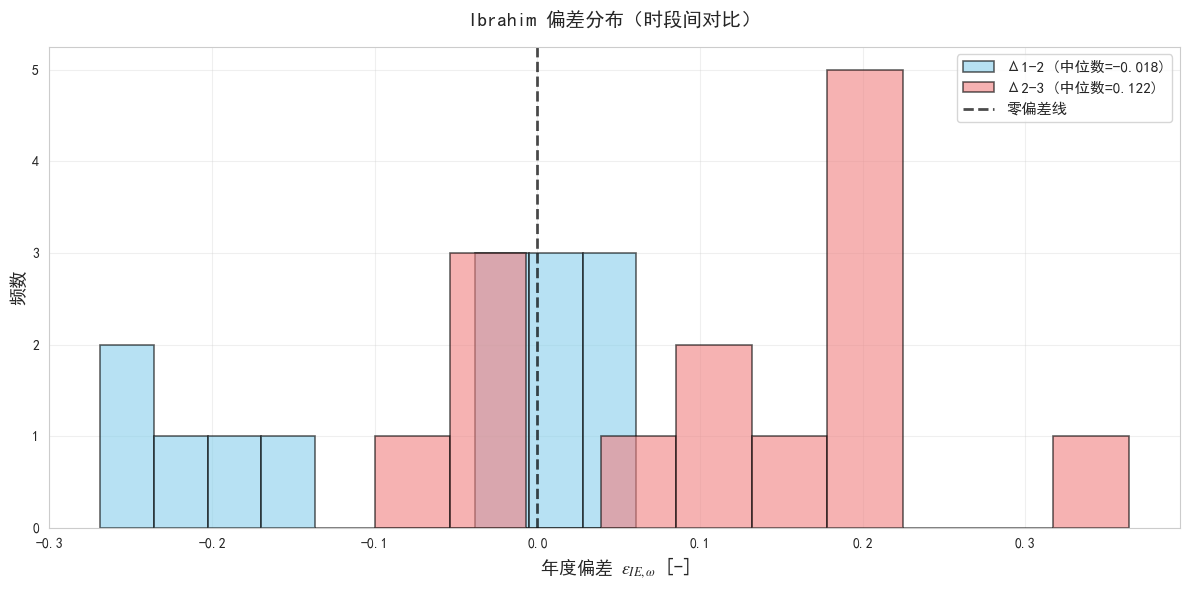


图解读：
  - 每个柱状图代表一个时段对的偏差分布
  - 如果分布集中在 0 附近，说明流域变化不大
  - 如果分布偏离 0，说明流域发生了系统性变化


In [17]:
# 绘制偏差分布直方图
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['skyblue', 'lightcoral']
for i, (pair_name, dev_result) in enumerate(deviation_results.items()):
    dist = dev_result['distribution']
    ax.hist(dist.annual_deviations, bins=10, alpha=0.6, 
            label=f'{pair_name} (中位数={dist.median:.3f})',
            color=colors[i], edgecolor='black', linewidth=1.2)

# 添加零线
ax.axvline(0, color='k', linestyle='--', linewidth=2, alpha=0.7, label='零偏差线')

ax.set_xlabel('年度偏差 $\\varepsilon_{IE,\\omega}$ [-]', fontsize=13)
ax.set_ylabel('频数', fontsize=13)
ax.set_title('Ibrahim 偏差分布（时段间对比）', fontsize=14, fontweight='bold', pad=15)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n图解读：")
print("  - 每个柱状图代表一个时段对的偏差分布")
print("  - 如果分布集中在 0 附近，说明流域变化不大")
print("  - 如果分布偏离 0，说明流域发生了系统性变化")

# 第八部分：Jaramillo (2022) 轨迹分析

## 什么是轨迹分析?

Jaramillo et al. (2022) 提出了一个新颖的视角：将流域在 Budyko 空间中的变化看作一种**运动**。

就像物理学中的质点运动一样，我们可以定义：
- **起点**：第 1 时段的平均位置 $(IA_1, IE_1)$
- **终点**：第 3 时段的平均位置 $(IA_3, IE_3)$
- **运动向量**：$\vec{v} = (\Delta IA, \Delta IE)$
- **运动强度**：$I = |\vec{v}| = \sqrt{(\Delta IA)^2 + (\Delta IE)^2}$
- **运动方向**：$\theta = \arctan2(\Delta IA, \Delta IE)$

## 运动方向的物理意义

Jaramillo 定义了特定的角度范围：
- **45°-90° 或 225°-270°**：流域沿着 Budyko 曲线运动（"遵循曲线"）
- **其他角度**：流域偏离 Budyko 曲线运动（可能受人类活动或其他因素影响）

---

## 8.1 计算运动轨迹


In [18]:
print("=" * 80)
print("计算 Budyko 空间运动轨迹 (T1 → T3)")
print("=" * 80)

traj_analyzer = TrajectoryAnalyzer()

# 计算从第 1 时段到第 3 时段的运动
movement = traj_analyzer.calculate_movement(
    catchment_id=data['basin_id'].iloc[0],
    period_1={
        'IA': periods[0]['IA_mean'],
        'IE': periods[0]['IE_mean'],
        'name': f"T1 ({periods[0]['start_year']}-{periods[0]['end_year']})"
    },
    period_2={
        'IA': periods[-1]['IA_mean'],
        'IE': periods[-1]['IE_mean'],
        'name': f"T3 ({periods[-1]['start_year']}-{periods[-1]['end_year']})"
    },
    reference_omega=periods[0]['omega']
)

print(f"起点 (T1): IA={movement.ia_t1:.3f}, IE={movement.ie_t1:.3f}")
print(f"终点 (T3): IA={movement.ia_t2:.3f}, IE={movement.ie_t2:.3f}")
print(f"\n运动特征:")
print(f"  - 运动强度: {movement.intensity:.4f}")
print(f"  - 方向角: {movement.direction_angle:.1f}°")
print(f"  - 遵循 Budyko 曲线: {'是' if movement.follows_curve else '否'}")
print(f"  - 运动类型: {movement.movement_type}")
print(f"\n解读:")
if movement.follows_curve:
    print("  流域的演变符合 Budyko 理论预期，沿着曲线运动。")
    print("  这说明流域主要受气候因素控制，人为干扰较小。")
else:
    print("  流域的演变偏离了 Budyko 曲线的方向。")
    print("  这可能是由于人类活动（如灌溉、水库）或其他非气候因素造成的。")

计算 Budyko 空间运动轨迹 (T1 → T3)
起点 (T1): IA=1.520, IE=0.576
终点 (T3): IA=1.659, IE=0.635

运动特征:
  - 运动强度: 0.1514
  - 方向角: 66.8°
  - 遵循 Budyko 曲线: 是
  - 运动类型: Following_Aridification_Evap_increase

解读:
  流域的演变符合 Budyko 理论预期，沿着曲线运动。
  这说明流域主要受气候因素控制，人为干扰较小。


## 8.2 可视化运动轨迹


In [ ]:
# 可视化 Budyko 平面中的运动轨迹
fig, ax1 = plt.subplots(figsize=(8, 6))

ia_theory = np.linspace(0.1, 3, 500)
ie_theory = budyko_curves.tixeront_fu(ia_theory, periods[0]['omega'])
ax1.plot(ia_theory, ie_theory, 'k-', linewidth=2.5, label=f'Budyko曲线 (ω={periods[0]["omega"]:.2f})', alpha=0.7)

for i, p in enumerate(periods):
    ax1.scatter(p['IA_mean'], p['IE_mean'], s=200,
                label=f"{p['name']} ({p['start_year']}-{p['end_year']})",
                zorder=10, edgecolor='black', linewidth=2)

ax1.annotate('', xy=(movement.ia_t2, movement.ie_t2),
             xytext=(movement.ia_t1, movement.ie_t1),
             arrowprops=dict(arrowstyle='->', lw=3, color='red', alpha=0.7))

mid_ia = (movement.ia_t1 + movement.ia_t2) / 2
mid_ie = (movement.ie_t1 + movement.ie_t2) / 2
ax1.text(mid_ia, mid_ie + 0.05,
         f'运动强度: {movement.intensity:.3f}
方向: {movement.direction_angle:.0f}°',
         fontsize=10, ha='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

ax1.set_xlabel('干旱指数 $I_A$ = PET/P [-]', fontsize=12)
ax1.set_ylabel('蒸发指数 $I_E$ = EA/P [-]', fontsize=12)
ax1.set_title('Budyko 空间中的流域轨迹', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_xlim(0, 2.5)
ax1.set_ylim(0, 1.05)


In [ ]:
# 极坐标方向玫瑰图（运动方向）
fig_polar = plt.figure(figsize=(6, 6))
ax2 = fig_polar.add_subplot(111, projection='polar')

theta = np.deg2rad(movement.direction_angle)
r = movement.intensity

ax2.arrow(0, 0, theta, r, width=0.1, head_width=0.3, head_length=0.05,
          fc='red', ec='black', linewidth=2, length_includes_head=True,
          label='流域运动方向', zorder=10)
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)

follow_angles = [(45, 90), (225, 270)]
for angle_min, angle_max in follow_angles:
    theta_range = np.deg2rad(np.linspace(angle_min, angle_max, 50))
    ax2.fill_between(theta_range, 0, r * 1.5, alpha=0.2, color='green',
                     label='遵循曲线区域' if angle_min == 45 else '')

ax2.set_title('运动方向分析（Jaramillo方法）', fontsize=13, fontweight='bold', pad=20)
ax2.legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

print("图解读：左图展示 Budyko 平面轨迹，右图显示方向是否遵循曲线。")


# 第九部分：综合可视化

让我们将所有分析结果整合到一个综合图表中：


In [ ]:
# 综合图表：创建画布并绘制面板 1-2
print("=" * 80)
print("生成综合分析图表")
print("=" * 80)

fig = plt.figure(figsize=(18, 12))

ax1 = fig.add_subplot(2, 3, 1)
period_results = {p['name']: p for p in periods}
BudykoVisualizer.plot_catchment_trajectory(ax1, period_results, omega_reference=periods[0]['omega'])
ax1.set_title('A) Budyko空间流域轨迹', fontsize=12, fontweight='bold', loc='left')

ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(data['year'], data['PET_standard'], 'b-', label='标准PET', linewidth=2, alpha=0.8)
ax2.plot(data['year'], data['PET_innovation'], 'r-', label='创新PET (LAI+CO2)', linewidth=2, alpha=0.8)
ax2.set_xlabel('年份', fontsize=11)
ax2.set_ylabel('PET [mm/year]', fontsize=11)
ax2.set_title('B) PET方法对比', fontsize=12, fontweight='bold', loc='left')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)


In [ ]:
# 综合图表：绘制面板 3-4
ax3 = fig.add_subplot(2, 3, 3)
ax3_twin = ax3.twinx()
line1 = ax3.plot(data['year'], data['LAI'], 'g-', linewidth=2.5, label='LAI', alpha=0.8)
ax3.set_xlabel('年份', fontsize=11)
ax3.set_ylabel('LAI [m2/m2]', fontsize=11, color='g')
ax3.tick_params(axis='y', labelcolor='g')
line2 = ax3_twin.plot(data['year'], data['CO2'], 'orange', linewidth=2.5, label='CO2', alpha=0.8)
ax3_twin.set_ylabel('CO2 [ppm]', fontsize=11, color='orange')
ax3_twin.tick_params(axis='y', labelcolor='orange')
ax3.set_title('C) LAI与CO2时间演变', fontsize=12, fontweight='bold', loc='left')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, fontsize=10, loc='upper left')
ax3.grid(alpha=0.3)

ax4 = fig.add_subplot(2, 3, 4)
colors_dev = ['skyblue', 'lightcoral']
for i, (pair_name, dev_result) in enumerate(deviation_results.items()):
    dist = dev_result['distribution']
    ax4.hist(dist.annual_deviations, bins=10, alpha=0.6,
             label=f'{pair_name} (中位数={dist.median:.3f})',
             color=colors_dev[i], edgecolor='black', linewidth=0.8)
ax4.axvline(0, color='k', linestyle='--', linewidth=1.5, alpha=0.6)
ax4.set_xlabel('年度偏差 epsilon(IE,omega) [-]', fontsize=11)
ax4.set_ylabel('频数', fontsize=11)
ax4.set_title('D) 偏差分布（Ibrahim方法）', fontsize=12, fontweight='bold', loc='left')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)


In [ ]:
# 综合图表：绘制面板 5-6 并收尾
ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(data['year'], data['P'], 'b-', linewidth=2, label='降水 P', alpha=0.8)
ax5.plot(data['year'], data['Q'], 'r-', linewidth=2, label='径流 Q', alpha=0.8)
ax5.plot(data['year'], data['EA'], 'g-', linewidth=2, label='实际蒸发 EA = P - Q', alpha=0.8)
ax5.set_xlabel('年份', fontsize=11)
ax5.set_ylabel('水量 [mm/year]', fontsize=11)
ax5.set_title('E) 水量平衡组分', fontsize=12, fontweight='bold', loc='left')
ax5.legend(fontsize=10)
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(2, 3, 6)
ax6_twin = ax6.twinx()
line1 = ax6.plot(data['year'], data['IA'], 'purple', linewidth=2.5, label='IA = PET/P', alpha=0.8)
ax6.set_xlabel('年份', fontsize=11)
ax6.set_ylabel('干旱指数 IA [-]', fontsize=11, color='purple')
ax6.tick_params(axis='y', labelcolor='purple')
ax6.axhline(1, color='purple', linestyle=':', alpha=0.5, linewidth=1.5)
line2 = ax6_twin.plot(data['year'], data['IE'], 'teal', linewidth=2.5, label='IE = (P-Q)/P', alpha=0.8)
ax6_twin.set_ylabel('蒸发指数 IE [-]', fontsize=11, color='teal')
ax6_twin.tick_params(axis='y', labelcolor='teal')
ax6.set_title('F) Budyko指数时间演变', fontsize=12, fontweight='bold', loc='left')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax6.legend(lines, labels, fontsize=10, loc='upper left')
ax6.grid(alpha=0.3)

plt.suptitle('Budyko 水文能量平衡综合分析', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ 综合分析图表生成完成！")


# 第十部分：总结与思考

## 🎓 我们学到了什么？

通过本教程，我们：

1. **理解了 Budyko 框架的核心概念**
   - 干旱指数 $I_A = PET/P$（需水/供水）
   - 蒸发指数 $I_E = EA/P = (P-Q)/P$（实际蒸发占降水的比例）
   - Fu-Budyko 曲线方程及其物理意义

2. **认识到径流数据（Q）的核心地位**
   - 没有 Q，我们就无法计算 EA，也就无法确定 $I_E$
   - Q 是连接 Budyko 理论与现实观测的唯一桥梁

3. **掌握了两种 PET 计算方法**
   - 标准方法（Penman-Monteith FAO-56）
   - 创新方法（考虑 LAI 和 CO₂）
   - 认识到植被动态和 CO₂ 施肥效应的重要性

4. **学习了前沿的 Budyko 分析方法**
   - **Ibrahim (2025) 偏差分析**：量化流域偏离 Budyko 曲线的幅度和时间稳定性
   - **Jaramillo (2022) 轨迹分析**：分析流域在 Budyko 空间中的运动方向和强度

5. **培养了数据分析和可视化能力**
   - 使用 Python 进行水文数据处理
   - 创建有意义的科学图表

---

## 💡 关键要点回顾

### 水量平衡方程
$$
P = EA + Q + \Delta S \quad \Rightarrow \quad EA \approx P - Q
$$

### Budyko 指数
$$
I_A = \frac{PET}{P}, \quad I_E = \frac{EA}{P} = \frac{P - Q}{P}
$$

### Fu-Budyko 曲线
$$
I_E = 1 + I_A - \left(1 + I_A^\omega\right)^{1/\omega}
$$

### 径流数据的核心地位
> **Q 决定了蒸发指数 $I_E$ 的值，是 Budyko 分析的基石！**

---

## 🤔 思考题

1. **如果某流域的径流 Q 突然减少，但降水 P 不变，这会如何影响 Budyko 空间中的位置？**
   - 提示：考虑 $I_E = (P-Q)/P$ 的变化

2. **为什么 LAI 增加会导致 PET 变化？这对 Budyko 分析有什么影响？**
   - 提示：思考植被覆盖度与蒸腾作用的关系

3. **如果某流域的运动方向偏离了 Budyko 曲线，可能的原因有哪些？**
   - 提示：人类活动（灌溉、水库）、土地利用变化等

4. **为什么长时间尺度上可以假设 $\Delta S \approx 0$？**
   - 提示：储量变化在年际尺度上相互抵消

---

## 📚 进一步学习

如果你对 Budyko 分析感兴趣，可以：

1. 阅读原始文献：
   - Budyko, M. I. (1974). *Climate and Life*.
   - Fu, B. P. (1981). On the calculation of the evaporation from land surface.
   - Ibrahim, B., et al. (2025). On the Need to Update the Water-Energy Balance Framework.
   - Jaramillo, F., et al. (2022). Fewer Basins Will Follow Their Budyko Curves.

2. 探索本代码库的其他功能：
   - `examples/` 文件夹中的其他示例脚本
   - `docs/` 文件夹中的详细文档

3. 使用真实数据进行分析：
   - 下载 Caravan 流域数据集
   - 获取 CMFD 气象数据
   - 应用本教程的方法进行研究

---

## 🙏 致谢

感谢你完成本教程！希望你对 Budyko 水文能量平衡框架有了深入的理解。

如有任何问题或建议，欢迎通过 GitHub Issues 联系我们。

**祝学习愉快，研究顺利！** 🌊📊
